# Figure 1

- Goal of this notebook is to make Figure 1 for our manuscript
- We need one overal term to describe the global trend of extreme heat events over time

#### Dependencies

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as seabornInstance 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import statsmodels.api as sm
import seaborn as sns
import glob

#### Make Data Function

In [77]:
def make_pdays(df_stats, df_pop):
    
    # Make Population Long Format
    pop_long = pd.wide_to_long(df_pop, stubnames = 'P', i = 'ID_HDC_G0', j = 'year')
    pop_long.reset_index(level=0, inplace=True)
    pop_long.reset_index(level=0, inplace=True)
    pop_long = pop_long.drop('Unnamed: 0', axis = 1)
    
    # Get Total Days 
    data = df_stats.drop_duplicates(['year', 'ID_HDC_G0'], keep = 'first') # drop out duplicates
    pdays = pd.DataFrame()
    pdays['ID_HDC_G0'] = data['ID_HDC_G0']
    pdays['year'] = data['year']
    pdays['total_days'] = data['total_days']
    pdays['CTR_MN_NM'] = data['CTR_MN_NM']
    pdays['sub-region'] = data['sub-region']
    pdays['region'] = data['region']
    pdays['intermediate-region'] = data['intermediate-region']
    
    # Merge
    pdays_merge = pdays.merge(pop_long, on=['ID_HDC_G0', 'year'], how = 'left')

    # Now get people days from 1983
    p83 = pd.DataFrame()
    p83['ID_HDC_G0'] = df_pop['ID_HDC_G0']
    p83['P1983'] = df_pop['P1983']

    pdays_merge = pdays_merge.merge(p83, on=['ID_HDC_G0'], how = 'left')
    
    # Calc p days
    pdays_merge['people_days'] = pdays_merge['total_days'] * pdays_merge['P'] / 10**9 # total people days
    pdays_merge['people_days_83'] = pdays_merge['total_days'] * pdays_merge['P1983'] / 10**9 # people days w/ pop con
    pdays_merge['people_days_attr'] = pdays_merge['people_days'] - pdays_merge['people_days_83']  # dif
    
    return pdays_merge

# Make Data 

#### Load and arrange data

In [78]:
# file paths
DATA_IN = "/home/cascade/projects/data_out_urbanheat/"  # Note: Need ?dl=1 to make sure this file gets read correctly
FN_stats = 'All_data20191109_final.csv'
df_stats = pd.read_csv(DATA_IN+FN_stats)
# FIG_OUT = '/home/cascade/projects/figures/'

# FN_pop = 'GHS-UCDB-Interp.csv'
# df_pop = pd.read_csv(DATA_IN+FN_pop)

In [79]:
# Get File list
# fn_list = glob.glob(DATA_IN+'heatrange/*.csv')

In [80]:
df_stats.head()

,Unnamed: 0,CTR_MN_NM,Event_ID,GCPNT_LAT,GCPNT_LON,ID_HDC_G0,avg_intensity,avg_temp,duration,event_dates,intensity,intermediate-region,region,sub-region,tmax,tot_intensity,total_days,year,start_date
0,0,Germany,1,48.138002,11.563435,2784,3.859750,44.459750,1,['1983.07.27'],[3.85975],Western Europe,Europe,Western Europe,[44.45975],3.859750,1,1983,1983.07.27
1,1,Germany,763005,48.138002,11.563435,2784,0.058337,40.658337,1,['2013.08.06'],[0.058337],Western Europe,Europe,Western Europe,[40.658337],0.058337,1,2013,2013.08.06
2,2,Germany,4,47.849642,12.102591,2833,6.893180,47.493180,1,['1983.07.27'],[6.89318],Western Europe,Europe,Western Europe,[47.49318],6.893180,1,1983,1983.07.27
3,3,Germany,22703,47.849642,12.102591,2833,1.187350,41.787350,1,['1984.07.11'],[1.18735],Western Europe,Europe,Western Europe,[41.78735],1.187350,1,1984,1984.07.11
4,4,Germany,349979,47.849642,12.102591,2833,0.793425,41.393425,1,['1998.08.11'],[0.793425],Western Europe,Europe,Western Europe,[41.393425],0.793425,1,1998,1998.08.11


In [81]:
FN_pop = 'GHS-UCDB-Interp.csv'
df_pop = pd.read_csv(DATA_IN+FN_pop)

In [82]:
df_data = make_pdays(df_stats, df_pop)

# People Days

In [92]:
geog = 'sub-region'

In [93]:
list(np.unique(df_data[geog]))

['Australia and New Zealand',
 'Central Asia',
 'Eastern Asia',
 'Eastern Europe',
 'Latin America and the Caribbean',
 'Northern Africa',
 'Northern America',
 'Northern Europe',
 'South-eastern Asia',
 'Southern Asia',
 'Southern Europe',
 'Sub-Saharan Africa',
 'Western Asia',
 'Western Europe']

In [124]:
len(list(np.unique(df_data['year'])))

34

In [94]:
# styles
kwargs = {'linewidth':0.7, 'marker': 'o'} #linestyle: '--'

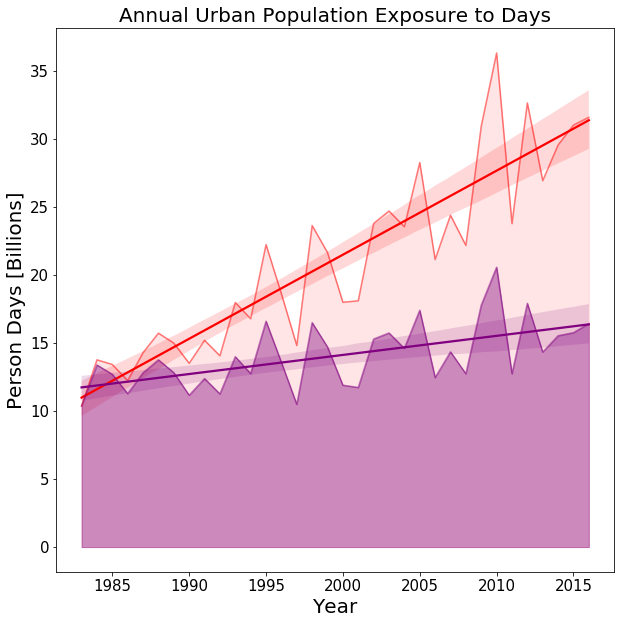

In [166]:
# Global 

fig, ax1 = plt.subplots(1, figsize = (10,10), sharex=True)

# people days plot
data = df_data.groupby('year')['people_days'].sum()
years = list(data.index)
ax1.plot(data, color = 'red', linestyle = '-', alpha = 0.5)
ax1.fill_between(years, data, color = 'red', alpha = 0.1, label='_nolegend_')
sns.regplot(years, data, color = 'red', ax = ax1, scatter = False, truncate = True)

# people days 83 plot
data = df_data.groupby('year')['people_days_83'].sum()
years = list(data.index)
ax1.plot(data, color = 'purple', linestyle = '-', alpha = 0.5)
ax1.fill_between(years, data, color = 'purple', alpha = 0.4, label='_nolegend_')
sns.regplot(years, data, color = 'purple', ax = ax1, scatter = False, truncate = True)

# Title
ax1.set_title('Annual Urban Population Exposure to Days', fontsize = 20)
ax1.set_ylabel('Person Days [Billions]', fontsize = 20)
ax1.set_xlabel('Year', fontsize = 20)
ax1.tick_params(labelsize = 15)

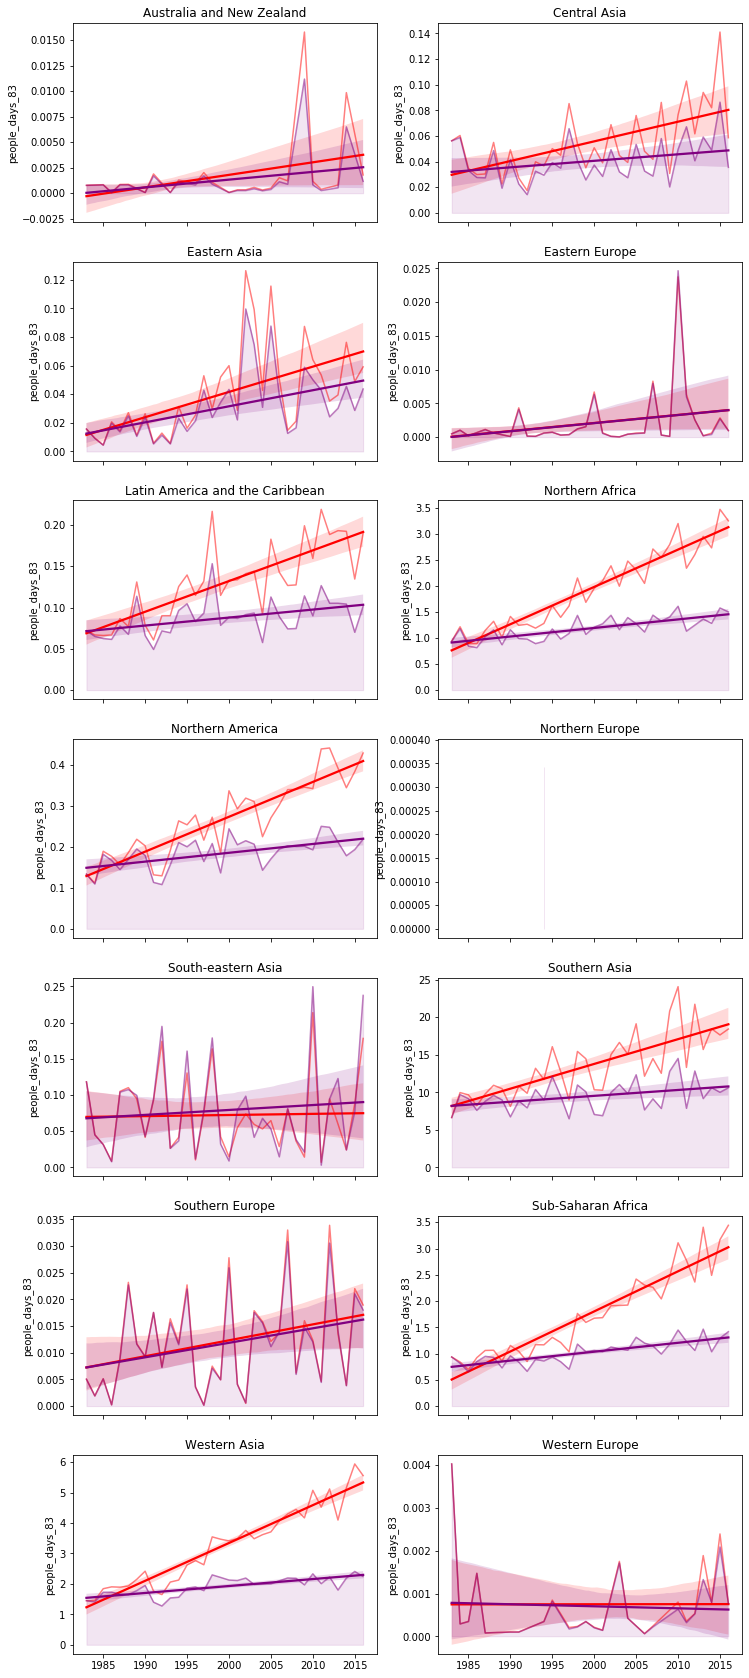

In [157]:
# plot by region

fig, axs = plt.subplots(7,2, figsize = (12,30), sharex=True)

axs = axs.ravel()

for i, region in enumerate(list(np.unique(df_data[geog]))):
    
    # people days plot
    data = df_data[df_data[geog] == region].groupby('year')['people_days'].sum()
    years = list(data.index)
    axs[i].plot(data, color = 'red', linestyle = '-', alpha = 0.5)
    #axs[i].fill_between(years, data, color = 'red', alpha = 0.1, label='_nolegend_')
    sns.regplot(years, data, color = 'red', ax = axs[i], scatter = False, truncate = True)
    
    # people days 83 plot
    data = df_data[df_data[geog] == region].groupby('year')['people_days_83'].sum()
    years = list(data.index)
    axs[i].plot(data, color = 'purple', linestyle = '-', alpha = 0.5)
    axs[i].fill_between(years, data, color = 'purple', alpha = 0.1, label='_nolegend_')
    sns.regplot(years, data, color = 'purple', ax = axs[i], scatter = False, truncate = True)
    
    # Title
    axs[i].title.set_text(region)


34


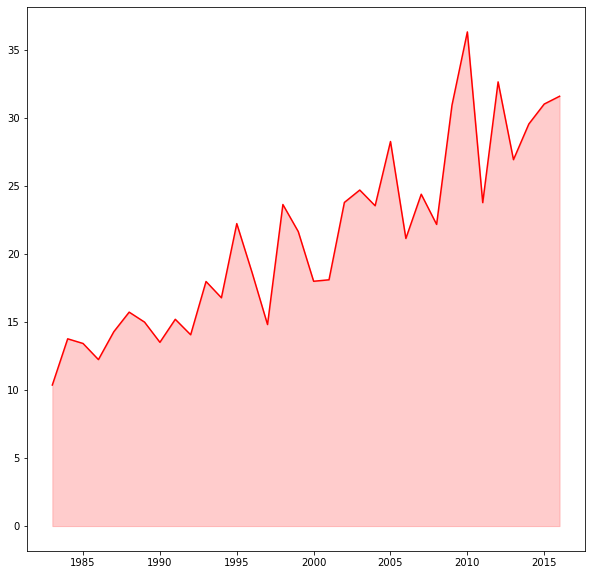

In [122]:
fig, ax1 = plt.subplots(1, figsize = (10,10), sharex=True)

top = df_data.groupby(['year'])['people_days'].sum()
print(len(top))
ax1.plot(top, color = 'red', linestyle = '-')
ax1.fill_between(years, top, color = 'red', alpha = 0.2, label='_nolegend_')


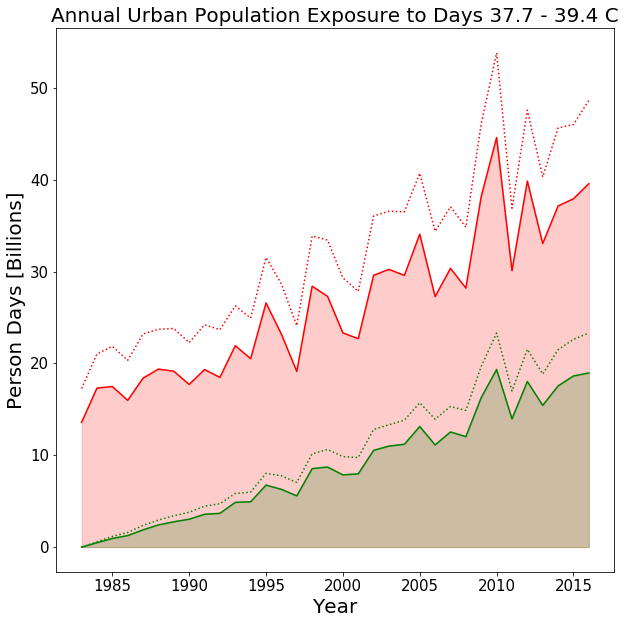

In [9]:
fig, ax1 = plt.subplots(1, figsize = (10,10), sharex=True)

top = data_list[3].groupby(['year'])['people_days'].sum()
ax1.plot(top, color = 'red', linestyle = '-')
ax1.fill_between(years, top, color = 'red', alpha = 0.2, label='_nolegend_')
bottom = data_list[0].groupby(['year'])['people_days'].sum()
ax1.plot(bottom, color = 'red', linestyle = ':')

top = data_list[3].groupby(['year'])['people_days_attr'].sum()
ax1.plot(top, color = 'green', linestyle = '-')
ax1.fill_between(years, top, color = 'green', alpha = 0.2, label='_nolegend_')
bottom = data_list[0].groupby(['year'])['people_days_attr'].sum()
ax1.plot(bottom, color = 'green', linestyle = ':')


# bottom = data_list[3].groupby(['year'])['people_days'].sum()
# ax1.plot(bottom, color = 'red')
# ax1.fill_between(years, top, color = 'red', alpha = 0.2, label='_nolegend_', linestyle = '-')
# # ax1.plot(data_list[1].groupby(['year'])['people_days'].sum())
# #ax1.plot(data_list[2].groupby(['year'])['people_days'].sum())
# bottom = data_list[3].groupby(['year'])['people_days'].sum()
# ax1.plot(bottom, color = 'red')
# #ax1.fill_between(years, top, color = 'red', alpha = 0.2, label='_nolegend_', linestyle = '-')

# # top = data_list[0].groupby(['year'])['people_days_attr'].sum()
# # ax1.plot(top, color = 'green')
# # # ax1.plot(data_list[1].groupby(['year'])['people_days'].sum())
# # # ax1.plot(data_list[2].groupby(['year'])['people_days'].sum())
# # bottom = data_list[3].groupby(['year'])['people_days_attr'].sum()
# # ax1.plot(bottom, color = 'green')
# # ax1.fill_between(years, bottom, color = 'green', alpha = 0.2, label='_nolegend_')


# Title
ax1.set_title('Annual Urban Population Exposure to Days 37.7 - 39.4 C', fontsize = 20)
ax1.set_ylabel('Person Days [Billions]', fontsize = 20)
ax1.set_xlabel('Year', fontsize = 20)
ax1.tick_params(labelsize = 15)

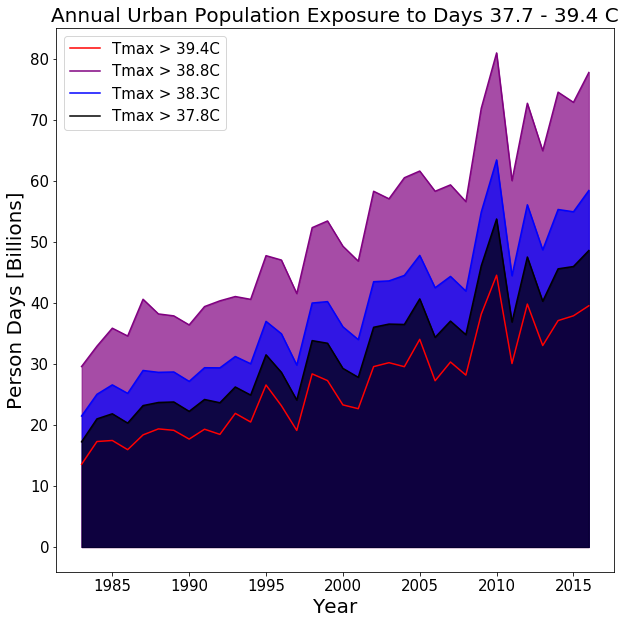

In [10]:
fig, ax1 = plt.subplots(1, figsize = (10,10), sharex=True)

top = data_list[3].groupby(['year'])['people_days'].sum()
ax1.plot(top, color = 'red', linestyle = '-')
ax1.fill_between(years, top, color = 'red', alpha = 0.7, label='_nolegend_')

top = data_list[2].groupby(['year'])['people_days'].sum()
ax1.plot(top, color = 'purple', linestyle = '-')
ax1.fill_between(years, top, color = 'purple', alpha = 0.7, label='_nolegend_')

top = data_list[1].groupby(['year'])['people_days'].sum()
ax1.plot(top, color = 'blue', linestyle = '-')
ax1.fill_between(years, top, color = 'blue', alpha = 0.7, label='_nolegend_')

top = data_list[0].groupby(['year'])['people_days'].sum()
ax1.plot(top, color = 'black', linestyle = '-')
ax1.fill_between(years, top, color = 'black', alpha = 0.7, label='_nolegend_')

# legend <<<<<--- Need  to fix this
leg_labels = ['Tmax > 39.4C', 'Tmax > 38.8C', 'Tmax > 38.3C', 'Tmax > 37.8C']
plt.legend(leg_labels, fontsize = 15)

# Title
ax1.set_title('Annual Urban Population Exposure to Days 37.7 - 39.4 C', fontsize = 20)
ax1.set_ylabel('Person Days [Billions]', fontsize = 20)
ax1.set_xlabel('Year', fontsize = 20)
ax1.tick_params(labelsize = 15)

## Let's explore the data

In [ ]:
df_stats.head()

In [ ]:
df_pop.head()

## Make Population Long Format

In [ ]:
# Make Population Long Format

pop_long = pd.wide_to_long(df_pop, stubnames = 'P', i = 'ID_HDC_G0', j = 'year')
pop_long.reset_index(level=0, inplace=True)
pop_long.reset_index(level=0, inplace=True)
pop_long = pop_long.drop('Unnamed: 0', axis = 1)

In [ ]:
pop_long

## Calc People Days

In [ ]:
# Get Total Days 

data = df_stats.drop_duplicates(['year', 'ID_HDC_G0'], keep = 'first') # drop out duplicates

pdays = pd.DataFrame()
pdays['ID_HDC_G0'] = data['ID_HDC_G0']
pdays['year'] = data['year']
pdays['total_days'] = data['total_days']
pdays['CTR_MN_NM'] = data['CTR_MN_NM']
pdays['sub-region'] = data['sub-region']

In [ ]:
# Try to merge with Pdays
print(len(pdays))
pdays_merge = pdays.merge(pop_long, on=['ID_HDC_G0', 'year'], how = 'left')
print(len(pdays_merge))

In [ ]:
pdays_merge.head()

In [ ]:
# Now get people days from 1983

p83 = pd.DataFrame()
p83['ID_HDC_G0'] = df_pop['ID_HDC_G0']
p83['P1983'] = df_pop['P1983']


pdays_merge = pdays_merge.merge(p83, on=['ID_HDC_G0'], how = 'left')


In [ ]:
# Calc p days
pdays_merge['people_days'] = pdays_merge['total_days'] * pdays_merge['P'] / 10**9 # total people days
pdays_merge['people_days_83'] = pdays_merge['total_days'] * pdays_merge['P1983'] / 10**9 # people days w/ pop con
pdays_merge['people_days_attr'] = pdays_merge['people_days'] - pdays_merge['people_days_83']  # dif


In [ ]:
pdays_merge.head(4)

# Plot People Days Total

In [ ]:
# styles
kwargs = {'linewidth':0.7, 'marker': 'o'} #linestyle: '--'

# Make Years List
years = np.unique(df_stats['year'])
years

#### People Days with population backed out
The idea here is for a given year we sum across all cities such that:
- pdays = #days for year X times (pop year x - population 1983)

In [ ]:
fig, ax1 = plt.subplots(1, figsize = (10,10), sharex=True)

# Total People Day
data = pdays_merge.groupby(['year'])['people_days'].sum()
ax1.plot(years, data, color = 'green', alpha = 0.1)
ax1.fill_between(years, data, color = 'green', alpha = 0.2, label='_nolegend_')

# People Days Dif 83 and total
data = pdays_merge.groupby(['year'])['people_days_attr'].sum()
ax1.plot(data, color = 'red', alpha = 0.4)
ax1.fill_between(years, data, color = 'red', alpha = 0.4)

# add trend line
data = pdays_merge.groupby(['year'])['people_days'].sum()
sns.regplot(years, data, color = 'green', ax = ax1, scatter = False)
data = pdays_merge.groupby(['year'])['people_days_attr'].sum()
sns.regplot(years, data, color = 'red', ax = ax1, scatter = False)

# Title
ax1.set_title('Annual Urban Population Exposure to Days >40.6 C', fontsize = 20)
ax1.set_ylabel('Person Days [Billions]', fontsize = 20)
ax1.set_xlabel('Year', fontsize = 20)
ax1.tick_params(labelsize = 15)

# legend <<<<<--- Need  to fix this

# leg_labels = ['People Days', 'People Days, 1983 population constant']
# plt.legend(leg_labels, fontsize = 15)

#plt.savefig(FIG_OUT+'AGU_Global_PersonDays.png')

#### Population held at 1983

In [ ]:
fig, ax1 = plt.subplots(1, figsize = (10,10), sharex=True)

# Total People Days
data = pdays_merge.groupby(['year'])['people_days'].sum()
ax1.plot(years, data, color = 'green', alpha = 0.1)
ax1.fill_between(years, data, color = 'green', alpha = 0.2, label='_nolegend_')

# People Days w/ 83 Pop
data = pdays_merge.groupby(['year'])['people_days_83'].sum()
ax1.plot(data, color = 'blue', alpha = 0.4)
ax1.fill_between(years, data, color = 'blue', alpha = 0.4)

# add trend line
data = pdays_merge.groupby(['year'])['people_days'].sum()
sns.regplot(years, data, color = 'green', ax = ax1, scatter = False)
data = pdays_merge.groupby(['year'])['people_days_83'].sum()
sns.regplot(years, data, color = 'blue', ax = ax1, scatter = False)

# Title
ax1.set_title('Annual Urban Population Exposure to Days >40.6 C', fontsize = 20)
ax1.set_ylabel('Person Days [Billions]', fontsize = 20)
ax1.set_xlabel('Year', fontsize = 20)
ax1.tick_params(labelsize = 15)

# legend <<<<<--- Need  to fix this

# leg_labels = ['People Days', 'People Days, 1983 population constant']
# plt.legend(leg_labels, fontsize = 15)

#plt.savefig(FIG_OUT+'AGU_Global_PersonDays.png')

# Test for some individual countries

In [ ]:
# By Country

loc = 'India'
geog = 'CTR_MN_NM'
subset = pdays_merge[pdays_merge[geog] == loc]
subset

In [ ]:
# By City
loc = 'Pop > 5m'
subset = pdays_merge[pdays_merge['P1983'] > 5*10**6]


#### People Days with population backed out
The idea here is for a given year we sum across all cities such that:
- pdays = #days for year X times (pop year x - population 1983)

In [ ]:
fig, ax1 = plt.subplots(1, figsize = (10,10), sharex=True)

# Total People Day
data = subset.groupby(['year'])['people_days'].sum()
ax1.plot(years, data, color = 'green', alpha = 0.1)
ax1.fill_between(years, data, color = 'green', alpha = 0.2, label='_nolegend_')

# # People Days Dif 83 and total
data = subset.groupby(['year'])['people_days_attr'].sum()
ax1.plot(data, color = 'red', alpha = 0.4)
ax1.fill_between(years, data, color = 'red', alpha = 0.4)

# # add trend line
data = subset.groupby(['year'])['people_days'].sum()
sns.regplot(years, data, color = 'green', ax = ax1, scatter = False)
data = subset.groupby(['year'])['people_days_attr'].sum()
sns.regplot(years, data, color = 'red', ax = ax1, scatter = False)

# # Title
ax1.set_title(loc + ' Annual Urban Population Exposure to Days >40.6 C', fontsize = 20)
ax1.set_ylabel('Person Days [Billions]', fontsize = 20)
ax1.set_xlabel('Year', fontsize = 20)
ax1.tick_params(labelsize = 15)

# legend <<<<<--- Need  to fix this

# leg_labels = ['People Days', 'People Days, 1983 population constant']
# plt.legend(leg_labels, fontsize = 15)

#plt.savefig(FIG_OUT+'AGU_Global_PersonDays.png')

#### Population held at 1983

In [ ]:
fig, ax1 = plt.subplots(1, figsize = (10,10), sharex=True)

# Total People Days
data = subset.groupby(['year'])['people_days'].sum()
ax1.plot(years, data, color = 'green', alpha = 0.1)
ax1.fill_between(years, data, color = 'green', alpha = 0.2, label='_nolegend_')

# People Days w/ 83 Pop
data = subset.groupby(['year'])['people_days_83'].sum()
ax1.plot(data, color = 'blue', alpha = 0.4)
ax1.fill_between(years, data, color = 'blue', alpha = 0.4)

# add trend line
data = subset.groupby(['year'])['people_days'].sum()
sns.regplot(years, data, color = 'green', ax = ax1, scatter = False)
data = subset.groupby(['year'])['people_days_83'].sum()
sns.regplot(years, data, color = 'blue', ax = ax1, scatter = False)

# Title
ax1.set_title('Annual Urban Population Exposure to Days >40.6 C', fontsize = 20)
ax1.set_ylabel('Person Days [Billions]', fontsize = 20)
ax1.set_xlabel('Year', fontsize = 20)
ax1.tick_params(labelsize = 15)

# legend <<<<<--- Need  to fix this

# leg_labels = ['People Days', 'People Days, 1983 population constant']
# plt.legend(leg_labels, fontsize = 15)

#plt.savefig(FIG_OUT+'AGU_Global_PersonDays.png')

# PEOPLE DAYS THROUGH TIME

In [ ]:
# file paths
DATA_IN = "/home/cascade/projects/data_out_urbanheat/"  # Note: Need ?dl=1 to make sure this file gets read correctly
DATA_IN_H = '/home/cascade/projects/data_out_urbanheat/heatrange/'
FIG_OUT = '/home/cascade/projects/figures/'

FN_pop = 'GHS-UCDB-Interp.csv'
df_pop = pd.read_csv(DATA_IN+FN_pop)

#
FN_stats = 'All_data20200102.csv'
df_stats105 = pd.read_csv(DATA_IN+FN_stats)
FN_stats = 'All_data20200109_377C.csv'
df_stats100 = pd.read_csv(DATA_IN_H+FN_stats)




# Old Code

#### Issues

- when using the first ten years there are nans because not all cities had a heat wave in the first ten years
- for now going to set all NANs to zero, but another solution is to just drop them
- another idea is just to use 1983 population as a baseline ... e.g. holding population constant what is the increase in people days by heat 

In [ ]:
# Now get avg number of days per year for each city and calc people days

# 34-year avg days per year
# avgdays = df_stats.drop_duplicates(['year', 'ID_HDC_G0'], keep = 'first') # drop out duplicates
# avgdays = avgdays.groupby('ID_HDC_G0')['total_days'].mean()

# first ten-year avg days per year
avgdays = df_stats.drop_duplicates(['year', 'ID_HDC_G0'], keep = 'first') # drop out duplicates
avgdays = avgdays[(avgdays['year'] >= 1983) & (avgdays['year'] <= 1992)]
avgdays = avgdays.groupby('ID_HDC_G0')['total_days'].mean()

# Try to merge with Pdays
print(len(pdays))
pdays_merge = pdays_merge.merge(avgdays, on=['ID_HDC_G0'], how = 'left')
print(len(pdays_merge))
pdays_merge = pdays_merge.rename(columns={'total_days_x': 'total_days', 'total_days_y': 'total_days_avg'})

In [ ]:
# Check for Nans
pdays_merge[pd.isnull(pdays_merge).any(axis=1)]

In [ ]:
# Fill nans
pdays_merge = pdays_merge.fillna(value = 0)

In [ ]:
pdays_merge.dtypes

In [ ]:
pdays_merge['people_days'] = pdays_merge['total_days'] * pdays_merge['P'] / 10**9
pdays_merge['people_days_avg'] = pdays_merge['total_days_avg'] * pdays_merge['P'] / 10**9


In [ ]:
pdays_merge.head()

## How has exposure changed overtime?
- First we do it with all data
- Second we do it holding 1983 population constant
- Third we do it with avg days split over 15 year periods (both with real population change and 1983 pop)
- Next we do it with avg days per year in ten year intervals (both with real population change and 1983 pop)

**OR WE DO DELTA POPULATION** !

In [ ]:
# styles
kwargs = {'linewidth':0.7, 'marker': 'o'} #linestyle: '--'

# Make Years List
years = np.unique(df_stats['year'])
years

In [ ]:
fig, ax1 = plt.subplots(1, figsize = (10,10), sharex=True)

# Total Days
data = pdays_merge.groupby(['year'])['people_days'].sum()
sns.regplot(years, data, color = 'green', ax = ax1)
ax1.plot(data, **kwargs, color = 'green')

# Total Days first ten avg 
data = pdays_merge.groupby(['year'])['people_days_avg'].sum()
#sns.regplot(years, data, color = 'red', ax = ax1)
ax1.plot(data, **kwargs, color = 'red')

ax1.set_title('Annual Urban Population Exposure to Days >40.6 C', fontsize = 20)
ax1.set_ylabel('Person Days [Billions]', fontsize = 20)
ax1.set_xlabel('Year', fontsize = 20)
ax1.tick_params(labelsize = 15)

#plt.savefig(FIG_OUT+'AGU_Global_PersonDays.png')

## What happens when we hold population constant?

In [ ]:
# Get Total Days 

data = df_stats.drop_duplicates(['year', 'ID_HDC_G0'], keep = 'first') # drop out duplicates

pdays = pd.DataFrame()
pdays['ID_HDC_G0'] = data['ID_HDC_G0']
pdays['year'] = data['year']
pdays['total_days'] = data['total_days']
pdays['CTR_MN_NM'] = data['CTR_MN_NM']
pdays['sub-region'] = data['sub-region']

p83 = pd.DataFrame()
p83['ID_HDC_G0'] = df_pop['ID_HDC_G0']
p83['P1983'] = df_pop['P1983']

pdays = pdays.merge(p83, on = 'ID_HDC_G0', how = 'left')

pdays_merge = pd.DataFrame()
pdays_merge = pdays.merge(pop_long, on=['ID_HDC_G0', 'year'], how = 'left')
pdays_merge.head()

In [ ]:
pdays_merge['people_days'] = pdays_merge['total_days'] * pdays_merge['P'] / 10**9
pdays_merge['people_days_83'] = pdays_merge['total_days'] * pdays_merge['P1983'] / 10**9


In [ ]:
fig, ax1 = plt.subplots(1, figsize = (10,10), sharex=True)

# Total Days
data = pdays_merge.groupby(['year'])['people_days'].sum()
#sns.regplot(years, data, color = 'green', ax = ax1, label='_nolegend_')
ax1.plot(data, **kwargs, color = 'green')

# Total Days first ten avg 
data = pdays_merge.groupby(['year'])['people_days_83'].sum()
#sns.regplot(years, data, color = 'red', ax = ax1)
ax1.plot(data, **kwargs, color = 'red')

# Title
ax1.set_title('Annual Urban Population Exposure to Days >40.6 C', fontsize = 20)
ax1.set_ylabel('Person Days [Billions]', fontsize = 20)
ax1.set_xlabel('Year', fontsize = 20)
ax1.tick_params(labelsize = 15)

# legend
leg_labels = ['People Days', 'People Days, 1983 population constant']
plt.legend(leg_labels, fontsize = 15)

#plt.savefig(FIG_OUT+'AGU_Global_PersonDays.png')

# What happens when we only look at incease in people, not days?

In [ ]:
fig, ax1 = plt.subplots(1, figsize = (10,10), sharex=True)

# Total Days
data = pdays_merge.groupby(['year'])['people_days'].sum()
#sns.regplot(years, data, color = 'green', ax = ax1, label='_nolegend_')
ax1.plot(data, **kwargs, color = 'green')

# Total Days first ten avg 
data = pdays_merge.groupby('year')['P'].sum() / 10**9
#sns.regplot(years, data, color = 'red', ax = ax1)
ax1.plot(data, **kwargs, color = 'red')

# Title
ax1.set_title('Annual Urban Population Exposure to Days >40.6 C', fontsize = 20)
ax1.set_ylabel('Person Days [Billions]', fontsize = 20)
ax1.set_xlabel('Year', fontsize = 20)
ax1.tick_params(labelsize = 15)

# legend
leg_labels = ['People Days', 'People Days, 1983 population constant']
plt.legend(leg_labels, fontsize = 15)

#plt.savefig(FIG_OUT+'AGU_Global_PersonDays.png')

In [ ]:
pdays_merge.groupby('year')['P'].sum()

In [ ]:
fig, ax1 = plt.subplots(1, figsize = (10,10), sharex=True)


# Total Days first ten avg 
data = pdays_merge.groupby('year')['P'].sum() / 10**9
#sns.regplot(years, data, color = 'red', ax = ax1)
ax1.plot(data, **kwargs, color = 'red')

# What happens when we look at per capita change?

In [ ]:
# How many people in a given year were exposed?

total_people = pdays_merge.groupby('year')['P'].sum()
total_days = pdays_merge.groupby('year')['total_days'].sum()

In [ ]:
fig, ax1 = plt.subplots(1, figsize = (10,10), sharex=True)

# Total Days
data = total_people / total_days
#sns.regplot(years, data, color = 'green', ax = ax1, label='_nolegend_')
ax1.plot(data, **kwargs, color = 'green')

# Title
ax1.set_title('Per Capital Annual Urban Population Exposure to Days >40.6 C', fontsize = 20)
ax1.set_ylabel('Tot # of People Expose / Tot. # Days [Global]', fontsize = 20)
ax1.set_xlabel('Year', fontsize = 20)
ax1.tick_params(labelsize = 15)

# legend
# leg_labels = ['People Days', 'People Days, 1983 population constant']
# plt.legend(leg_labels, fontsize = 15)

#plt.savefig(FIG_OUT+'AGU_Global_PersonDays.png')

In [ ]:
(4*(400/(400+200)) + 6*(200/600)) + 7*

In [ ]:
400/(400+200)

# What happens when we only look at people-events?

In [ ]:
data = df_stats

edays = pd.DataFrame()
edays['ID_HDC_G0'] = data['ID_HDC_G0']
edays['year'] = data['year']
edays['total_days'] = data['total_days']
edays['CTR_MN_NM'] = data['CTR_MN_NM']
edays['sub-region'] = data['sub-region']

In [ ]:
edays.groupby(['year','ID_HDC_G0'])['total_days'].count()

In [15]:
data_list = []

for fn in fn_list:
    df_stats = pd.read_csv(fn)
    df_stats = make_pdays(df_stats, df_pop)
    data_list.append(df_stats)

KeyError: 'sub-region'